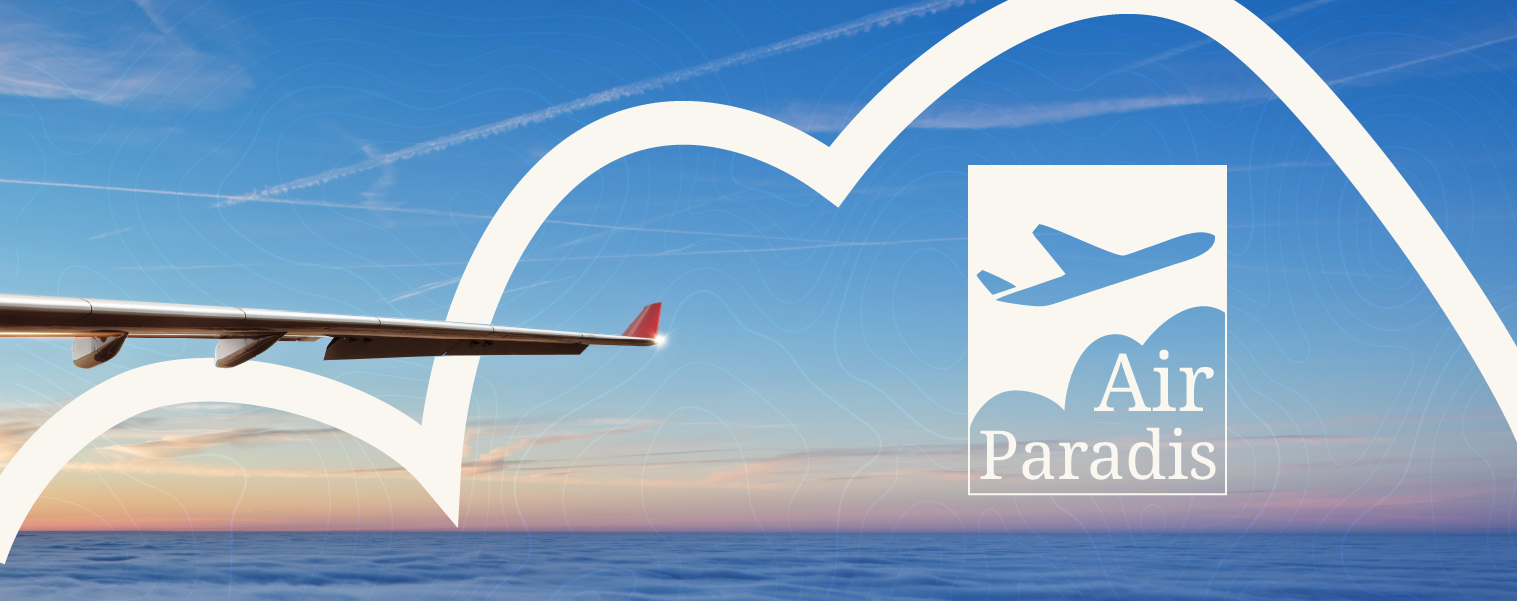

### Réalisez une analyse de sentiments grâce au Deep Learning

### Présentation du projet

Dans ce projet, notre mission principale est de développer une application de Machine Learning utilisant les techniques du traitement du langage naturel (NLP) afin de prédire les sentiments des tweets écrit par les clients. L'objectif derrière tout ça est d'être en mesure de prédire les bad buzz et d'y remédier avant qu'il ne soit trop tard.

Pour se faire, nous utilisons des données open source ne provenant pas d'Air Paradis. Les données utilisées sont des tweets accompagnés d'un label, 0 si le tweet est négatif et 4 si le tweet est positif.

### Importation et installation des bibliothèques

In [1]:
!pip install keras

In [5]:
!pip install tensorflow

In [6]:
!pip install transformers

In [54]:
!pip install h5py

In [2]:
!pip install wordcloud

  Using cached wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.3-cp311-cp311-win_amd64.whl (300 kB)


In [4]:
!pip install torch

  Using cached torch-2.2.2-cp311-cp311-win_amd64.whl.metadata (26 kB)
Using cached torch-2.2.2-cp311-cp311-win_amd64.whl (198.6 MB)


In [6]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import nltk
import gensim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
import scipy.sparse
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from transformers import RobertaTokenizer, RobertaModel
from transformers import BertTokenizer
import tensorflow as tf
import mlflow.pytorch
import mlflow.keras
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

### Importer et explorer les données

In [7]:
data = pd.read_csv('projet_seven.csv', delimiter=',', header=None, skiprows=[5312], encoding='latin1')

In [8]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
# Définir une liste des nouveaux noms de colonnes
new_columns = ['Label', 'Id', 'Date', 'Query', 'name', 'Text']

# Renommer les colonnes du DataFrame
data.columns = new_columns

data.head()

,Label,Id,Date,Query,name,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Label   1599999 non-null  int64 
 1   Id      1599999 non-null  int64 
 2   Date    1599999 non-null  object
 3   Query   1599999 non-null  object
 4   name    1599999 non-null  object
 5   Text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


La base de données fournie ne présente aucune valeur manquante.

In [11]:
data.nunique()

Label          2
Id       1598314
Date      774362
Query          1
name      659775
Text     1581465
dtype: int64

Les variables qui nous intéressent sont 'Label' qui exprime le sentiment du tweet et 'Text' qui représente le texte du tweet en anglais.

In [12]:
data.isna().sum()

Label    0
Id       0
Date     0
Query    0
name     0
Text     0
dtype: int64

In [13]:
data.describe()

,Label,Id
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [14]:
data.describe(include ='O')

,Date,Query,name,Text
count,1599999,1599999,1599999,1599999
unique,774362,1,659775,1581465
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1599999,549,210


### Constitution de notre dataframe de travail

In [15]:
# choix des colonnes de nore nouveau dataframe
cols = ["Label", "Text"]
df = data[cols]
df.head()

,Label,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [16]:
df.shape

(1599999, 2)

In [17]:
df.isna().mean()

Label    0.0
Text     0.0
dtype: float64

Comme indiqué précédement, les deux variables qui nous intéressent dans ce projet sont 'Label' et 'Text' et naturellement nous gardons uniquement ces deux variables pour constituer notre dataframe pour la suite des opérations.

### Prétraitement et analyse de la variable "Label"

La variable "Label" est notre variable target.

0 signifie que le tweet est classé négatif et 4 signifie que le tweet est annoté poistif.

Le 0 sera maintenu 0 et signifiera toujours que le tweet est classé négatif. 

En revanche le 4 sera ramplacé par 1 car c'est plus conventionnel.

Désormais, le label 1 signifie que le tweet est classé positif.

In [18]:
# Remplacer les labels dans la colonne Label
df['Label'] = df['Label'].replace({0: 0, 4: 1})


In [19]:
# Pour les valeurs dupliquées
idx = df.duplicated(subset="Text", keep= "first")
df.loc[idx, : ].sort_values("Text")

,Label,Text
271504,0,David must be hospitalized for five days end...
1132075,1,bathroom is clean..... now on to more enjoya...
540172,0,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
1364946,1,#seb-day #seb-day #seb-day #seb-day #seb-day ...
331062,0,*tear*
...,...,...
1375801,1,youtube.
256596,0,yuckkk its pouring rain &amp; im filthy now!! ...
458169,0,"zofran is not making this work day any easier,..."
464809,0,~ get SUICIDE !!


Nous avons 18534 valeurs dupliquées. Celles-ci seront supprimées.

In [20]:
# Supprimer les valeurs dupliquées en se basant sur la colonne "Text"
df = df.drop_duplicates(subset="Text", keep="first")

In [21]:
df.Label.value_counts()

Label
1    791281
0    790184
Name: count, dtype: int64

<Axes: ylabel='count'>

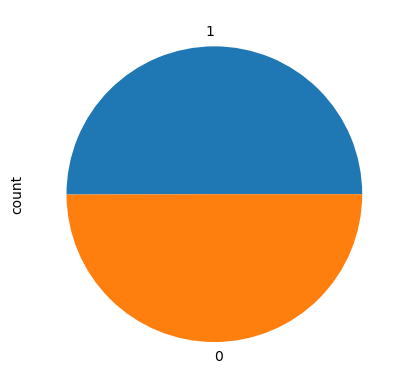

In [22]:
df.Label.value_counts().plot(kind='pie')

La distribution des labels est équilibrée. C'est une excellente nouvelle car cela permet d'avoir un entrainement plus cohérent de nos modèles et évite certaines opérations qui peuvent s'avérer chronophages.

### Analyse de la variable "Text"

In [23]:
# Nombre de caractéres par observation
df.Text.apply(lambda i : len(i))

0          115
1          111
2           89
3           47
4          111
          ... 
1599994     56
1599995     78
1599996     57
1599997     65
1599998     62
Name: Text, Length: 1581465, dtype: int64

<Axes: >

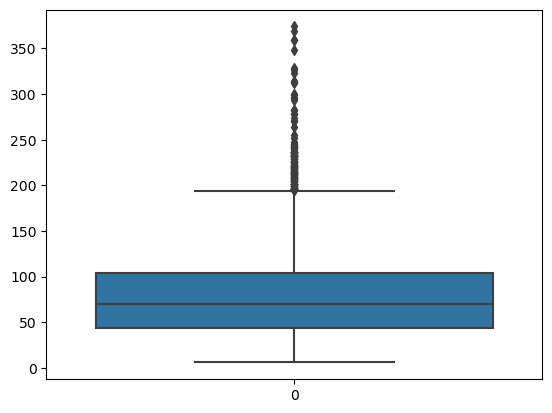

In [24]:
len_text = df.Text.str.len()
sns.boxplot(len_text)

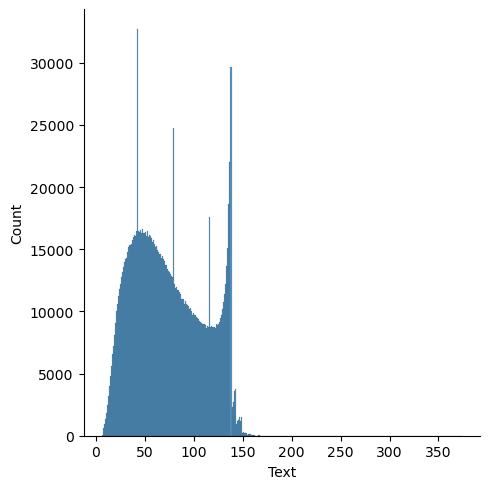

In [25]:
sns.displot(len_text)

La majeur partie des tweets comprend moins de 150 caractères.
Il existe, néanmoins, quelques valeurs abérantes qu'il convient de supprimer car les tweets trop longs peuvent affecter la cohérence des données et n'aideraient pas le modèle à se concentrer sur les informations les plus pertinentes.

In [26]:
# Filtrer les tweets ayant 3 caractères ou moins et les tweets de plus de 200 caractères
df = df[(df['Text'].apply(lambda x: len(x) > 3)) & (df['Text'].apply(lambda x: len(x) <= 200))]

<Axes: >

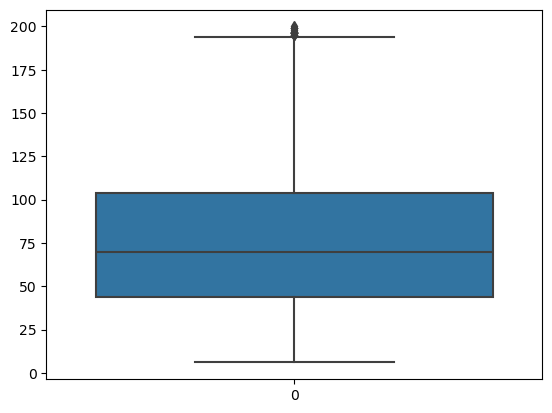

In [27]:
len_text = df.Text.str.len()
sns.boxplot(len_text)

In [28]:
df.shape

(1581339, 2)

Nous nous retrouvons avec un dataframe de 1581339 observations et deux variables.

### Explorer superficiellement le corpus

In [30]:
df_samp = df.sample(20)
df_samp

,Label,Text
274054,0,Why do we always want what we can't have?! It ...
70583,0,is way too stressed
633134,0,@granulac You're leaving for #PDX soon? So jea...
999196,1,@Nuthinlika9er Thank you! Happy Belated! Mine ...
1195512,1,@lizconno he did it for my birthday! He told m...
692365,0,Driving the van to Richmond... Hate driving th...
26719,0,@lyjahmarie 6AM :/ its bad enough that im up a...
854078,1,@Ed_Dale Can't wait! The music! The people! T...
1207145,1,@VickyArdon haha I laughed aloud at your use o...
935774,1,"@liftedresearch hurray, just got my stickers, ..."


In [31]:
# J'imprime 20 descriptions au hasard
for idx, ser in df_samp.iterrows():
    txt = f"label : {ser['Label']}\n"
    print(txt + ser['Text'] + "..." + "\n\n")

label : 0
Why do we always want what we can't have?! It all sucks! ...


label : 0
is way too stressed ...


label : 0
@granulac You're leaving for #PDX soon? So jealous, I have two more months to wait.  Don't use up all the awesome....


label : 1
@Nuthinlika9er Thank you! Happy Belated! Mine is today... ...


label : 1
@lizconno he did it for my birthday! He told me!! ...


label : 0
Driving the van to Richmond... Hate driving this thing! ...


label : 0
@lyjahmarie 6AM :/ its bad enough that im up at 6:30 but 6AM oh god.  i cant eat in the morning  makes me feel urgh horrible....


label : 1
@Ed_Dale Can't wait!  The music! The people! The shows! The glamour!...


label : 1
@VickyArdon haha I laughed aloud at your use of the word bitch. ...


label : 1
@liftedresearch hurray, just got my stickers, 8 in the morning.. sweet awekening ...


label : 0
Yeahhh this is weekend but I spend my time to study in anderson library.. ...


label : 0
nobody knows this but me but my underwear and m

L'exploration de 20 descriptions au hazard donne des résultats satisfaisants en terme de cohérence des description avec les catégories assignées. 

### Séléction d'un échantillion aléatoire de travail

A des fins de tests, nous choisissons de travailler avec un échantillon de données dans un premier temps et une fois le modèle finale désigné, nous l'entrainerons sur l'ensemble des données disponibles.

In [32]:
# Sélectionner un échantillon aléatoire de travail
df_work = df.sample(n=20000, random_state=42)  # Sélectionne 100000 lignes aléatoires du DataFrame

### Custom stop words

La liste stopwords de Nltk étant générique, il convient de personnaliser notre propre liste de stopwords.

La stratégie sera d'éliminer les tokens qui sont des signes de ponctuation et dont la longueur est inférieure à 3 caractères. Nous éliminons, par la suite, les 15 mots les plus fréquents ainsi que les mots ayant une faible occurrence (1 apparition), nous supprimons aussi les mots ayants au moins un caractère numérique.

La raison étant d'ajouter à notre liste de stopwords personnalisée tous les mots ayant un faible pouvoir informatif et dont la présence peut augmenter la complexité du modèle sans qu'il y ait de bénéfices en retour.

In [33]:
# Création du corpus sur la colonne description
print("Création du corpus sur la colonne description...")
corpus = " ".join(df_work['Text'].values)

# Tokenization et enlèvement des stopwords anglais
print("Tokenization et enlèvement des stopwords anglais...")
tokens = word_tokenize(corpus.lower())
stop_words = set(nltk_stopwords.words('english'))
tokens = [w for w in tokens if w not in stop_words]

# Lemmatisation
print("Lemmatisation des tokens...")
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(token) for token in tokens]

# Enlèvement de la ponctuation et des mots courts
print("Enlèvement de la ponctuation et des mots courts...")
tokens = [token for token in tokens if token not in string.punctuation and len(token) >= 3]

# Création d'un DataFrame contenant les mots uniques et leur fréquence
print("Création d'un DataFrame contenant les mots uniques et leur fréquence...")
word_freq = Counter(tokens)
freq_word = pd.DataFrame({'Mots': list(word_freq.keys()), 'Apparition': list(word_freq.values())})
freq_word_sorted = freq_word.sort_values(by='Apparition', ascending=False)

# Sélection des 30 mots les plus fréquents
print("Sélection des 15 mots les plus fréquents...")
most_common_words = freq_word_sorted['Mots'].head(30).values.tolist()
print(most_common_words)

# Sélection des mots apparaissant une seule fois
print("Sélection des mots apparaissant une seule fois...")
single_occurrence_words = freq_word[freq_word['Apparition'] == 1]['Mots'].tolist()

# Création de la liste personnalisée de stopwords
print("Création de la liste personnalisée de stopwords...")
custom_stop_words = most_common_words + single_occurrence_words + list(stop_words)
custom_stop_words = set(custom_stop_words)

# Ajout des tokens numériques à la liste de stopwords personnalisée
numeric_tokens = [token for token in tokens if token.isdigit()]
tokens_with_numeric_value = [token for token in tokens if any(char.isdigit() for char in token)]
custom_stop_words.update(set(numeric_tokens))
custom_stop_words.update(set(tokens_with_numeric_value))

print(f"Nombre de mots total dans la liste custom_stop_words : {len(custom_stop_words)}")

# Affichage de la fréquence d'apparition des mots dans l'ordre décroissant
print("Affichage de la fréquence d'apparition des mots dans l'ordre décroissant :")
freq_word_sorted = freq_word.sort_values(by='Apparition', ascending=False)
print(freq_word_sorted.head(20))  # Affichage des 20 premières lignes pour un aperçu

Création du corpus sur la colonne description...
Tokenization et enlèvement des stopwords anglais...
Lemmatisation des tokens...
Enlèvement de la ponctuation et des mots courts...
Création d'un DataFrame contenant les mots uniques et leur fréquence...
Sélection des 15 mots les plus fréquents...
['...', "n't", 'day', 'good', 'get', 'like', 'quot', 'today', 'http', 'love', 'got', 'work', 'going', 'lol', 'time', 'one', 'back', 'know', 'want', 'really', 'night', 'see', 'amp', 'think', "'ll", 'thanks', 'well', 'still', 'home', 'new']
Sélection des mots apparaissant une seule fois...
Création de la liste personnalisée de stopwords...
Nombre de mots total dans la liste custom_stop_words : 22498
Affichage de la fréquence d'apparition des mots dans l'ordre décroissant :
       Mots  Apparition
6       ...        2787
71      n't        2140
62      day        1274
59     good        1125
186     get        1052
208    like        1036
31     quot         921
267   today         910
11     http 

### Words cloud

Un word cloud ou nuage de mots en français est une représentation visuelle des mots les plus fréquents dans un texte. 

Dans le cadre de ce notebook, nous utilisons cette représentation pour avoir un aperçu des mots présents dans notre texte en prenant le soin de faire une distinction en fonction du label.

Ainsi, nous affichons les mots les plus fréquents dans les textes du label 0 (négatif) et le label 1 (positif).

Le but étant de chercher une certaine cohérence mais également pour pouvoir apprécier la portée de notre stratégie de choix de nos 'custom stop words'.
.
.
.

Generating word cloud for category: 0
Step 1: Tokenizing and lemmatizing the text...
Step 2: Generating word cloud...
Step 3: Plotting word cloud...


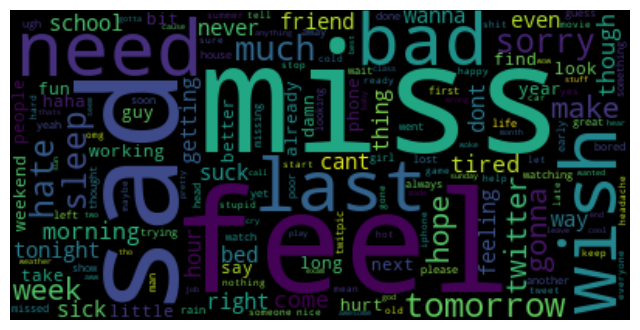

Generating word cloud for category: 1
Step 1: Tokenizing and lemmatizing the text...
Step 2: Generating word cloud...
Step 3: Plotting word cloud...


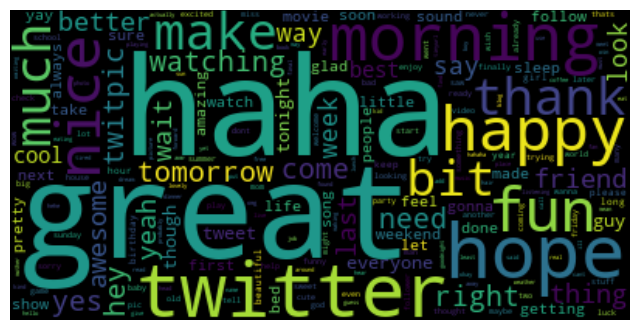

In [34]:
# Définir la fonction generate_wordcloud avec les paramètres requis
def generate_wordcloud(text, custom_stop_words=None, collocations=False, normalize_plurals=True, include_numbers=False, min_word_length=3):
    

    print("Step 1: Tokenizing and lemmatizing the text...")
    # Tokenize the text using NLTK's WordPunctTokenizer
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove custom stopwords, punctuation, and numbers
    tokens = [token for token in tokens if token not in custom_stop_words]
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if len(token) >= min_word_length]
    if not include_numbers:
        tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

    # Join the filtered tokens to form a clean text
    cleaned_corpus = ' '.join(tokens)

    print("Step 2: Generating word cloud...")
    # Generate word cloud with specified parameters
    wordcloud_params = {
        'collocations': collocations,
        'normalize_plurals': normalize_plurals,
        'include_numbers': include_numbers,
        'min_word_length': min_word_length,
        'stopwords': None
    }

    # Generate word cloud
    wordcloud = WordCloud(**wordcloud_params).generate(cleaned_corpus)

    print("Step 3: Plotting word cloud...")
    # Plot word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Grouper les textes par catégorie
grouped = df_work.groupby('Label')['Text'].apply(' '.join)

# Appliquer generate_wordcloud à chaque groupe de textes
for category, text in grouped.items():
    print(f"Generating word cloud for category: {category}")
    generate_wordcloud(text, custom_stop_words=custom_stop_words)  # Utilisation de la liste custom_stop_words

Dans l'ensemble, nos deux word cloud sont assez cohérents.

### Prétraitement de la variable "Text"

#### Lemmatization

La lemmatisation ou lemmatization en anglais est une technique qui relève du NLP et qui consiste à réduire les mots à leur forme de base ou canonique appelée "lemme". 
Vulgairement, nous pouvons dire que la lemmatisation consiste à analyser lexicalement du texte en vue de regrouper les mots par famille.
La lemmatisation prend en compte le contexte et le rôle grammatical des mots pour les ramener à leur forme de bas.

Par exemple le lemme des mots petits, petites, petit, petite est petit.
De même, est, suis, sois, étais auront pour lemme être.


In [35]:
# Fonction pour lemmatiser le texte en tenant compte des mots vides personnalisés
def lemmatize_text(text, stop_words):
    # Tokenization et enlèvement des stopwords 
    tokens = word_tokenize(text.lower())
    stop_words = custom_stop_words
    tokens = [w for w in tokens if w not in stop_words]

    # Lemmatisation avec NLTK
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens
                         if (token not in custom_stop_words
                             and token not in string.punctuation
                             and not token.isdigit()
                             and len(token) >= 3)]
    return ' '.join(lemmatized_tokens)


# Appliquer la fonction à la colonne 'description' de final_df
df_work['text_cleaned'] = df_work['Text'].apply(lambda x: lemmatize_text(x, custom_stop_words))

#### Stemming

Le stemming est une autre technique utilisée pour préparer les textes à usage en NLP. Cette technique consiste à réduire les mots à leur racine ou base formelle appelée 'stem'.
Cette technique présente un défaut par rapport à lemmatisation, c'est qu'elle se contente d'éliminer les suffixes des mots sans tenir compte des variations contextuelles ou de la validité grammaticale.

In [36]:
# Fonction de stemming
def stem_text(text, custom_stop_words):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Initialisation du stemmer
    stemmer = PorterStemmer()

    # Stemming de chaque token
    stemmed_tokens = [stemmer.stem(token) for token in tokens
                      if (token not in custom_stop_words
                          and token not in string.punctuation
                          and not token.isdigit()
                          and len(token) >= 3)]

    # Joindre les tokens stemmés en une seule chaîne de texte
    stemmed_text = ' '.join(stemmed_tokens)

    return stemmed_text

# Appliquer la fonction de stemming à la colonne 'text' de votre DataFrame
df_work['text_stemmed'] = df_work['Text'].apply(lambda x: stem_text(x, custom_stop_words))

In [37]:
df_work

,Label,Text,text_cleaned,text_stemmed
1419043,1,OMG! To miss this warehouse sale would be a TR...,omg miss warehouse sale would tragedy april early,omg miss warehous sale would tragedi april earli
412032,0,I think i hurt my hand,hurt hand,hurt hand
86156,0,hey guys can some 1 add me please i need some ...,hey guy add please need friend,hey guy add pleas need friend
1135069,1,Dena you may use my laptop now,may use laptop,may use laptop
243858,0,"@allyheartsbb yeah, probably that is more nece...",yeah probably necessary parent college recently,yeah probabl necessari parent colleg recent
...,...,...,...,...
466157,0,@shilpig yes.. wanted to tell you but always r...,yes wanted tell always remembered hanging phone,ye want tell alway rememb hang phone
502215,0,@markhoppus and Mexico when? please!!! plase!...,markhoppus mexico please mexico love mexican f...,markhoppu mexico pleas mexico love mexican foo...
411402,0,@eazid: Darn @givemecherrypom We missed the #F...,darn missed firework billy bowleg pirate festi...,darn miss firework billi bowleg pirat festiv w...
539177,0,ugh i have a will to draw but no ideas,ugh draw idea,ugh draw idea


### Logistic Regression avec TF-Idf

La régression logistiqueest une technique statistique et d’apprentissage automatique utilisée pour la classification supervisée binaire (deux classes) ou multi classe (3 classes ou plus).

Elle prédit la probabilité qu’une observation appartienne à une catégorie ou à une autre. Le modèle se base sur la fonction logistique pour modéliser la probabilité d’appartenir à une classe.

Concrètement, la régression logistique calcule les chances que des entrées particulières aboutissent à un résultat spécifique. Dans le cadre d’une problématique NLP (natural language processing) et particulièrement dans le cadre d’une analyse de sentiments, ce modèle calcule la probabilité qu’un texte soit considéré comme véhiculant un sentiment positif ou un sentiment négatif.

Les coefficients du modèle sont estimés à partir des données d’entrainement en utilisant la méthode de la descente de gradient, le but étant de minimiser la fonction de perte.

A noter que la sortie d’un modèle de régression logistique n’est pas directement une classe (par exemple, positif ou négatif s’agissant d’un tweet) mais une probabilité d’appartenance à la classe 1 (positif par exemple). Cette probabilité est par la suite convertie en classe en se basant sur un seuil définit en fonction des besoins spécifique de l’étude réalisée.

#### Avec lemmatisation

In [38]:
# Spliter les données
X_train, X_test, y_train, y_test = train_test_split(df_work["text_cleaned"], df_work["Label"], test_size=0.2, random_state=42)

# Créer un vecteur TF-IDF
vectorizer = TfidfVectorizer()
X_train_lemm = vectorizer.fit_transform(X_train)
X_test_lemm = vectorizer.transform(X_test)
X_train_lemm = X_train_lemm.toarray()
X_test_lemm = X_test_lemm.toarray()


# Instancier l'expérimentation MLFlow
mlflow.set_experiment("Reg_Logistic_Model")
mlflow.sklearn.autolog()


# Créer et entraîner un modèle de régression logistique
with mlflow.start_run(run_name =  "reg_logistic_lemm_defaut"):
    model = LogisticRegression()
    model.fit(X_train_lemm, y_train)
    


2024/04/12 23:03:33 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


In [39]:
!pip install pyngrok

  Using cached pyngrok-7.1.6-py3-none-any.whl.metadata (7.4 kB)
Using cached pyngrok-7.1.6-py3-none-any.whl (22 kB)


In [40]:
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Settings the authtoken
NGROK_AUTH_TOKEN = '2eZ0udf84vN7Xjnxou0LadI0XUj_39Cuq8i5bZmtoih5hkoWy'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls= True)
print('MLflow Tracking UI:', ngrok_tunnel.public_url)

MLflow Tracking UI: https://6676-2a01-e0a-b7f-6c80-cd17-7c71-d0a2-dfd0.ngrok-free.app               


ERROR:pyngrok.process.ngrok:t=2024-04-13T04:07:19+0200 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=5fbb78e7ff78 clientid=11c073ae418ecbcb845713513a756fcc
ERROR:pyngrok.process.ngrok:t=2024-04-13T04:07:20+0200 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=81450d616292 err="session closed"
ERROR:pyngrok.process.ngrok:t=2024-04-13T18:19:13+0200 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=64e8a8e379cc clientid=11c073ae418ecbcb845713513a756fcc
ERROR:pyngrok.process.ngrok:t=2024-04-13T18:19:13+0200 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=81450d616292 err="session closed"
ERROR:pyngrok.process.ngrok:t=2024-04-13T18:19:14+0200 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: no such

Pour ce projet, nous avons choisi d'utiliser MLflow de façon différente. En effet, dans le cadre de la démarche MLOps, un de fondamentaux reste la collaboration entre les différentes équipes impliquées dans le projet ML.
En ce sens, l'outils Ngrok est parfait car il permet à un membre d'une équipe qui utilise MLflow sur sa machine locale de partager ses résultats avec ses collègues qui ne sont pas sur son réseau local.

Ngrok expose l'interface web de MLflow en démarrant un tunnel vers le port où MLflow est exécuté, dans notre expérience c'est le port 5000 qui est le port par défaut. On obtient donc une URL publique sécurisée qu'il est possible de partager.

Au moment de ce choix, motivé par l'essence même de MLOps, à savoir la collaboration, nous n'étions pas conscients qu'au moment d'exécuter notre modèle BERT, nous allions être confronté à un problème de taille, à savoir qu'il est impossible d'utiliser Ngrok dans un contexte où nous exécutions nos modèle sur le cloud, entre autres pour des raisons de sécurité de conformité.

Nous verrons plus loin qu'il est très compliqué d'écécuter BERT sans avoir recours à la puissance de calcul de GPUs disponible sur des plateformmes comme Kaggle ou Google Colab.
Par conséquent, la partie MLflow ne concernera que les modèles de régression logistique et LSTM.

L'accès à Ngrok se fait à partir de ce lien https://6676-2a01-e0a-b7f-6c80-cd17-7c71-d0a2-dfd0.ngrok-free.app.
Il permet d'accéder à toutes les expérimentations, aux artefacts et permet également de faire des comparaisons entre les différents modèles exécutés au travers de visuels très intuitifs.

In [41]:
!mlflow ui

^C


In [42]:
# Créer et entraîner un modèle de régression logistique
with mlflow.start_run(run_name =  "reg_logistic_lemm_max_iter200"):
    model_2 = LogisticRegression(max_iter = 200)
    model_2.fit(X_train_lemm, y_train)

2024/04/12 23:04:20 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


In [43]:
# Créer et entraîner un modèle de régression logistique
with mlflow.start_run(run_name =  "reg_logistic_lemm_max_iter400"):
    model_3 = LogisticRegression(max_iter = 400)
    model_3.fit(X_train_lemm, y_train)

2024/04/12 23:04:40 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


#### Avec stemming

In [44]:
# Spliter les données
X_train, X_test, y_train, y_test = train_test_split(df_work["text_stemmed"], df_work["Label"], test_size=0.2, random_state=42)

# Créer un vecteur TF-IDF
vectorizer = TfidfVectorizer()
X_train_stem = vectorizer.fit_transform(X_train)
X_test_stem = vectorizer.transform(X_test)

# Instancier l'expérimentation MLFlow
mlflow.set_experiment("Reg_Logistic_Model")
mlflow.sklearn.autolog()


# Créer et entraîner un modèle de régression logistique
with mlflow.start_run(run_name =  "reg_logistic_stemm_defaut"):
    model = LogisticRegression()
    model.fit(X_train_stem, y_train)
    

2024/04/12 23:04:58 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


In [45]:
# Vider la mémoire allouée par PyTorch (fonctionne également sur CPU)
torch.cuda.empty_cache()

### LSTM 

Passons maintenant à notre deuxième modèle : le LSTM. Mais d’abord, donnons un bref aperçu sur les réseaux de neurones récurrents (RNN) puisque le modèle LSTM en est une variante.

Les RNN sont des modèles de machine learning qui permettent d’analyser des séquences de données telles que du texte ou des séries temporelles etc. En ce sens les RNN sont très adaptés à des problématiques de traitement du langage naturel (NLP).

Les RNN possèdent une structure de boucle qui permet à l’information de circuler d’une époque de temps à la suivante ce qui signifie que les sorties à une époque dépendent des calculs effectués aux époques précédentes.
Les RNN possèdent des états cachés qui sont, en quelques sortes, le cœur du réseau, ces états cachés sont mis à jour à chaque séquence ou époque en prenant en compte l’entrée à l’instant t et l’état caché de l’instant t-1(h_(t-1)).

Mais la principale faiblesse des RNN classique est leur incapacité à capter les dépendances à long terme et en ce raison de la disparition du gradient pendant l’apprentissage des modèles et particulièrement lors de la rétropropagation.

Les LSTM permettent justement de pallier cette faiblesse car leur architecture sophistiquée permet de traiter des séquences plus longues et plus complexes et de capturer plus efficacement les dépendances à long terme.

Contrairement aux RNN classiques, les LSTM introduisent la notion de la cellule mémoire. Chaque cellule est composée de trois portes : une porte d’entrée, une porte de l’oubli et une porte de sortie. Ces portes gèrent le flux de l’information à l’intérieur de la cellule et permettent de garder, d’une part, l’information pertinente et d’autre part, de ne pas prendre en compte celle qui ne l’est pas. Ceci est possible car les LSTM utilisent deux états cachés : l’état caché à court terme h_t (à l’instar des RNN classiques) et l’état caché à long terme c_t (état de la cellule mémoire).

Pour déterminer quelles informations doivent être mises à jour dans la cellule mémoire (via une fonction sigmoïde), la porte d’entrée prend en entrée la valeur actuelle x_t ainsi que le précèdent état caché à court terme de la cellule mémoire h_(t-1) et génère un vecteur d’activation (via une fonction Tanh) qui représente les informations à ajouter à l’état de la cellule. On obtient, ainsi l’état précèdent de la cellule mémoire c_(t-1).

La porte de l’oubli permet, quant à elle, de supprimer les informations obsolètes de la cellule mémoire. Cela se fait grâce à une fonction sigmoïde qui prend en compte le précèdent état caché à long terme (c_(t-1)) et l’entrée actuelle x_t pour créer un vecteur d’activation qui détermine quelles informations doivent être oubliées. C’est ainsi qu’on obtient c_t.

La porte de sortie détermine la sortie à un instant donnée en utilisant la valeur actuelle x_t et l’état actuel de la cellule mémoire obtenu précédemment c_t. Ceci génère un autre vecteur d’activation qui détermine l’état actuel de la mémoire à court terme h_t.

L’action commune de ces trois portes et l’introduction de l’unité « cellule mémoire » permet de gérer correctement les dépendances à long terme et d’éviter le problème de la disparition du gradient ce qui rend l’apprentissage du modèle plus précis et plus fiable.

#### Avec Word2Vec


Word2Vec est un modèle de NLP développé par google et basé sur la technique de word embedding. Word2Vec produit des représentations vectorielles de mots où les mots qui ont un contexte, une sémantique et une syntaxe similaire sont représentés par des vecteurs proches dans le plan vectoriel. Ces vecteurs qui ne sont autre qu'une représentation numérique des mots sont appelés des embeddings.


In [46]:
from keras.layers import Embedding
def create_layer_embedding_word_2_vec(X, W2V_SIZE=300, W2V_WINDOW=7, W2V_EPOCH=32, W2V_MIN_COUNT=10, SEQUENCE_LENGTH=300, workers=32):
    documents = [text.split() for text in X]
    w2v_model = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=workers, epochs=W2V_EPOCH)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)
            
    embedding_layer_word_2_vec = Embedding(vocab_size, W2V_SIZE, trainable=False)

    
    return embedding_layer_word_2_vec


In [47]:
def get_model_lstm_embedding_pretrain(embedding, printing=False, metric=['accuracy', tf.keras.metrics.AUC()]):
    model = Sequential()
    model.add(embedding)
    print("Embedding layer added.")
    model.add(Dropout(0.1))
    print("Dropout layer added.")
    model.add(Bidirectional(LSTM(64)))
    print("Bidirectional LSTM layer added.")
    model.add(Dropout(0.2))
    print("Dropout layer added.")
    model.add(Dense(1, activation='sigmoid'))
    print("Dense layer added.")
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metric)
    return model

# Spliter les données
X_train, X_test, y_train, y_test = train_test_split(df_work["text_cleaned"], df_work["Label"], test_size=0.2, random_state=42)
    
embedding = create_layer_embedding_word_2_vec(X_train)
print("Embedding layer created.")

model = get_model_lstm_embedding_pretrain(embedding, printing=True)
print("Model created.")

# Tokeniser les textes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print("Tokenizer fitted on training data.")

# Définition du chemin de l'expérience MLflow
mlflow.set_experiment("Bidirectional_LSTM")

# Début de l'exécution MLflow
with mlflow.start_run(run_name =  "LSTM_Word2vec"):
    # Convertir les textes en séquences d'entiers
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    print("Training data converted to sequences.")

    # Remplir les séquences pour qu'elles aient toutes la même longueur
    SEQUENCE_LENGTH = 300
    X_train_padded = pad_sequences(X_train_sequences, maxlen=SEQUENCE_LENGTH)
    print(f"Training data padded to length {SEQUENCE_LENGTH}.")

    # Entraîner le modèle avec les vecteurs d'incorporation
    history = model.fit(X_train_padded, y_train, batch_size=32, epochs=5, validation_split=0.2)
    print("Model trained.")

    # Enregistrement des métriques dans MLflow
    for metric_name, metric_values in history.history.items():
        for i, metric_value in enumerate(metric_values):
            mlflow.log_metric(metric_name, metric_value, step=i)
    print("Metrics logged to MLflow.")

    # Enregistrez le modèle
    mlflow.keras.log_model(model, "Bidirectional_LSTM")
    
print(model.summary())

Embedding layer created.
Embedding layer added.
Dropout layer added.
Bidirectional LSTM layer added.
Dropout layer added.
Dense layer added.
Model created.
Tokenizer fitted on training data.
Training data converted to sequences.
Training data padded to length 300.
Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 63s 145ms/step - accuracy: 0.5233 - auc: 0.5350 - loss: 0.6915 - val_accuracy: 0.5909 - val_auc: 0.6595 - val_loss: 0.6715
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 171ms/step - accuracy: 0.6080 - auc: 0.6478 - loss: 0.6616 - val_accuracy: 0.6147 - val_auc: 0.6663 - val_loss: 0.6502
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 69s 171ms/step - accuracy: 0.6344 - auc: 0.6852 - loss: 0.6384 - val_accuracy: 0.6212 - val_auc: 0.6792 - val_loss: 0.6394
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 66s 164ms/step - accuracy: 0.6395 - auc: 0.6989 - loss: 0.6272 - val_accuracy: 0.6212 - val_auc: 0.6731 - val_loss: 0.6412
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 70s 175ms/step - accuracy: 0.6498 - auc: 0.7050 

2024/04/12 23:12:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Model trained.
Metrics logged to MLflow.


2024/04/12 23:12:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Dhaker\AppData\Local\Temp\tmprn8df558\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 300, 300)         │     2,334,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 300, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32, 128)              │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,895,929 (11.05 MB)

 Trainable params: 187,009 (730.50 KB)

 Non-trainable params: 2,334,900 (8.91 MB)

 Optimizer params: 374,020 (1.43 MB)

None


In [48]:
def test_tweets(model, tweets):
    for twt in tweets:
        print(twt)
        # Tokenisation des tweets
        twt = tokenizer.texts_to_sequences([twt])
        # Remplissage des séquences pour qu'elles aient la même longueur
        twt = pad_sequences(twt, maxlen=28, dtype='int32', padding='post', truncating='post', value=0)
        # Prédiction du sentiment
        sentiment = model.predict(twt, batch_size=1, verbose=2)[0]
        if sentiment > 0.5:
            print("Positive")
        else:
            print("Negative")

In [49]:
test_tweets(model, ['this flight was great'])

this flight was great
1/1 - 0s - 399ms/step
Positive


In [50]:
test_tweets(model, ['this flight was bad'])

this flight was bad
1/1 - 0s - 36ms/step
Positive


In [51]:
test_tweets(model, ['horrible'])

horrible
1/1 - 0s - 31ms/step
Positive


#### Avec Glove

Glove (Global Vectors for Word Representation) est un modèle de word embedding. Glove est entièrement basé sur une approche globale pour la création d'embeddings. Il commence par construire une matrice qui capte les fréquences de cooccurrence. Cette matrice sert à calculer la probabilité conditionnelle qu'un mot coexiste avec d'autres mots.

In [52]:
# Créer une couche d'embedding à partir de GloVe
def create_glove_embedding_layer(embedding_file_path, tokenizer, vocab_size, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(embedding_file_path, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in tokenizer.word_index:
                idx = tokenizer.word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=False)
    return embedding_layer

In [54]:
# Définir les paramètres de l'embedding et du LSTM
EMBEDDING_DIM = 100  # Dimension des embeddings GloVe
SEQUENCE_LENGTH = 300
LSTM_UNITS = 100

# Spliter les données
X_train, X_test, y_train, y_test = train_test_split(df_work["text_stemmed"], df_work["Label"], test_size=0.2, random_state=42)

# Créer le tokenizer et prétraiter les données
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_glove = pad_sequences(X_train_seq, maxlen=SEQUENCE_LENGTH)
X_test_glove = pad_sequences(X_test_seq, maxlen=SEQUENCE_LENGTH)

# Créer la couche d'embedding à partir de GloVe
embedding_file_path = 'C:/Users/Dhaker/Documents/Projet_7/glove.twitter.27B.200d.txt' # Chemin vers le fichier GloVe
embedding_layer = create_glove_embedding_layer(embedding_file_path, tokenizer, vocab_size, EMBEDDING_DIM)

# Définition du chemin de l'expérience MLflow
mlflow.set_experiment("Bidirectional_LSTM")
mlflow.sklearn.autolog()

# Début de l'exécution MLflow
with mlflow.start_run(run_name="LSTM_Glove"):
    model_2 = Sequential()
    model_2.add(embedding_layer)
    model_2.add(SpatialDropout1D(0.2))
    model_2.add(Bidirectional(LSTM(64)))
    model_2.add(Dense(1, activation='sigmoid'))  # Utilisation de 'sigmoid' pour la classification binaire

    # Compiler le modèle
    model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    # Entraîner le modèle
    history_2 = model_2.fit(X_train_glove, y_train, epochs=8, batch_size=64, validation_split=0.2)

    # Enregistrement des métriques dans MLflow
    for metric_name, metric_values in history_2.history.items():
        for i, metric_value in enumerate(metric_values):
            mlflow.log_metric(metric_name, metric_value, step=i)

    # Enregistrez le modèle
    mlflow.keras.log_model(model, "Bidirectional_LSTM")


# Afficher un résumé du modèle
print(model_2.summary())

Epoch 1/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.5064 - loss: 0.6931 - val_accuracy: 0.5584 - val_loss: 0.6843
Epoch 2/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - accuracy: 0.5569 - loss: 0.6862 - val_accuracy: 0.5863 - val_loss: 0.6767
Epoch 3/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - accuracy: 0.5788 - loss: 0.6766 - val_accuracy: 0.5916 - val_loss: 0.6703
Epoch 4/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.5797 - loss: 0.6713 - val_accuracy: 0.5944 - val_loss: 0.6670
Epoch 5/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.5950 - loss: 0.6633 - val_accuracy: 0.6025 - val_loss: 0.6626
Epoch 6/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 199ms/step - accuracy: 0.6035 - loss: 0.6632 - val_accuracy: 0.6000 - val_loss: 0.6629
Epoch 7/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 216ms/step - accuracy: 0.5994 - loss: 0.6609 - val_accuracy: 0.6116 - val_loss: 0.6599
Epoch 8/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - accuracy: 0.5941 - loss: 0.6623 - 

2024/04/12 23:27:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/04/12 23:27:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Dhaker\AppData\Local\Temp\tmp72eks_eg\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (64, 300, 100)         │       674,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (64, 300, 100)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (64, 128)              │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 927,929 (3.54 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 674,100 (2.57 MB)

 Optimizer params: 169,220 (661.02 KB)

None


In [55]:
test_tweets(model_2, ['this flight was great'])

this flight was great
1/1 - 1s - 1s/step
Positive


In [56]:
test_tweets(model_2, ['this flight was bad'])

this flight was bad
1/1 - 0s - 28ms/step
Positive


Le modèle LSTM Glove ne sempble pas trés efficace, il n'arrive pas à prédire la classe des deux exemples de tweets de test.

### Préparation à la mise en place de notre modèle BERT

Toutes la partie qui va suivre est éxécutée sur le cloud sur Google Colab. Par la suite nous avons mergé les deux notebook pour les besoins du projet.

### Importation des bibliothèques

In [ ]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.8 MB/s eta 0:00:00


In [ ]:
pip install transformers

In [ ]:
pip install tensorflow

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torch import nn, optim
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import gensim
import os
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import de ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import scipy.sparse
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from transformers import RobertaTokenizer, RobertaModel
from transformers import BertTokenizer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importer et explorer les données

In [ ]:
data = pd.read_csv('/content/drive/My Drive/df_kaggle.csv', delimiter=',', skiprows=[5312], encoding='latin1')

In [ ]:
data.head()

,Label,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581338 entries, 0 to 1581337
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Label   1581338 non-null  int64 
 1   Text    1581338 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.1+ MB


In [ ]:
data.nunique()

Label          2
Text     1581338
dtype: int64

In [ ]:
data.isna().sum()

Label    0
Text     0
dtype: int64

In [ ]:
data.describe()

,Label
count,1.581338e+06
mean,5.003225e-01
std,5.000001e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


### Bert pré entrainé

### Bert, Hugging Face

In [ ]:
import gc
gc.collect()

31

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Apr 17 14:57:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              50W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Entrainement d'un premier modèle avec un échantillion de données

### Modèle avec Early Stopping

Pour les besoins de ce projet, nous avons créé deux échantillons de données. Le premier comporte 20000 observations et a servi aux tests préalables. Le deuxième comprend 500000 données et a servi à l'entrainement du modèle final.

Le modèle final a donc été entrainé sur 500000 observations uniquement. Ce choix est délibéré car les modèles prennent beaucoup de temps à tourner et même en achetant des crédits sur Google Colab afin d'utiliser des GPUs plus puissants, chaque expérimentation prenait énormément de temps à calculer.

Nous avons fait le choix de créer des échantillons équilibrés c'est à dire qu'il y avait autant d'observations portant le label 0 que le label 1. 

Nous avons utilisé le early stopping pour tous nos tests. Le but est d'arrêter le calcul quand les performances commencent à se dégrader à mesure que les modèles traversaient les époques.

Nous avons testé deux modèles, l'un en gelant le modèle Bert c'est à dire en désactivant l'entrainement des couches pré-entrainées de telles sortes qu'elles ne soient pas réentraînées sur nos données et l'autre en entraînant notre modèle pré-entrainé sur l'ensemble de nos données.

Le but étant de voir quelle expérimentation fournit les meilleures performances. 

Les performances obtenues nous ont conduit à décider d'entrainer notre modèle final en gelant l'apprentissage sur l'ensemble de nos données.

En effet, le modèle sans gel produit de l'overfitting car la fonction de perte augmente à mesure que le modèle franchit les époques, de plus le calcul prend beaucoup plus de temps à se terminer et ce en raison du nombre de paramètres à entrainer qui n'est pas le même selon que nous sommes dans contexte sans gel ou avec gel.

Le modèle avec gel n'entraine que 768 paramètres contre 108 millions, environ, pour le modèle sans gel.

Idéalement, il aurait fallu rajouter une couche danse à notre modèle avec gel car le nombre de paramètres est trop bas ce qui risque d'altérer fortemesnt les performance du modèle de prédiction que nous cherchons à construire.
.


In [ ]:
# Déterminer le nombre d'observations à sélectionner dans chaque classe
num_samples_per_class = 300000

# Diviser le dataframe en deux parties selon les labels
df_label_0 = data[data['Label'] == 0]
df_label_1 = data[data['Label'] == 1]

# Sous-échantillonner chaque classe pour obtenir le nombre souhaité d'observations
df_label_0 = df_label_0.sample(n=num_samples_per_class, random_state=42)
df_label_1 = df_label_1.sample(n=num_samples_per_class, random_state=42)

# Concaténer les deux parties pour former un nouvel ensemble de données équilibré
df_balanced = pd.concat([df_label_0, df_label_1])

# Mélanger les données
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Afficher les informations sur le DataFrame équilibré
print(df_balanced.info())

# Sélectionner les 40 000 premières observations
df_balanced_test = df_balanced.head(20000)
df_balanced_final =  df_balanced.head(500000)

# Afficher la taille des deux base de test et finale
print("Taille de la base de données de test :", df_balanced_test.shape)
print("Taille de la base de données finale :", df_balanced_final.shape)

# Calcul des fréquences des valeurs de la variable cible et tri par ordre décroissant
print("Distribution de la variable Label dans df_balanced_test:")
print(df_balanced_test['Label'].value_counts().sort_values(ascending=False))

print("Distribution de la variable Label dans df_balanced_final:")
print(df_balanced_final['Label'].value_counts().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Label   600000 non-null  int64 
 1   Text    600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.2+ MB
None
Taille de la base de données de test : (20000, 2)
Taille de la base de données finale : (500000, 2)
Distribution de la variable Label dans df_balanced_test:
Label
0    10017
1     9983
Name: count, dtype: int64
Distribution de la variable Label dans df_balanced_final:
Label
1    250021
0    249979
Name: count, dtype: int64


### Avec gel du modèle BERT pré-entrainé

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Définition du modèle BERT à utiliser
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Chargement du tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Longueur maximale des séquences
MAX_LEN = 200

# Classe Dataset pour traiter les données
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Séparation des données en ensembles d'entraînement, de validation et de test
df_train, df_test = train_test_split(df_balanced_test, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

# Création des DataLoaders
BATCH_SIZE = 16
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['Text'].to_numpy(),
        targets=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size)
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


# Définition du modèle de classification
class SentimentClassifier(nn.Module):
    def __init__(self, PRE_TRAINED_MODEL_NAME, freeze_bert=False):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(outputs.pooler_output)
        return self.out(output).squeeze(-1)

# Configuration de l'appareil et du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test = SentimentClassifier(PRE_TRAINED_MODEL_NAME, freeze_bert=True)
model_test = model_test.to(device)

# Nombre de paramètres à entraîner
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model_test):,} paramètres à entraîner')

# Définition de l'optimiseur, du scheduler et de la fonction de perte
EPOCHS = 10
optimizer = AdamW(model_test.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.BCEWithLogitsLoss().to(device)

# Fonctions d'entraînement et d'évaluation
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze())
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            preds = torch.round(torch.sigmoid(outputs)).squeeze()
            correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)

# Définition du chemin de sauvegarde sur Kaggle
save_dir = '/kaggle/test/working'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Entraînement avec arrêt précoce
best_accuracy = 0
counter = 0
patience = 3

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(
        model_test, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model_test, val_data_loader, loss_fn, device, len(df_val)
    )
    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        counter = 0
        best_model_path = os.path.join(save_dir, 'bert_model_best.bin')
        torch.save(model_test.state_dict(), best_model_path)
        print("Best model saved with accuracy:", best_accuracy)
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered!")
        last_model_path = os.path.join(save_dir, 'bert_model_last.bin')
        if val_acc != best_accuracy:  # Ensure to save last model if it's not the best
            torch.save(model_test.state_dict(), last_model_path)
            print("Last model state saved before stopping.")
        break

Le modèle a 769 paramètres à entraîner
Epoch 1/10
Train loss 0.6942989304065704 accuracy 0.5280625
Val loss 0.6823889117240906 accuracy 0.5855
Best model saved with accuracy: tensor(0.5855, device='cuda:0', dtype=torch.float64)
Epoch 2/10
Train loss 0.6939999147057533 accuracy 0.5299375000000001
Val loss 0.6786454081535339 accuracy 0.5945
Best model saved with accuracy: tensor(0.5945, device='cuda:0', dtype=torch.float64)
Epoch 3/10
Train loss 0.6865101940631867 accuracy 0.552625
Val loss 0.6758310317993164 accuracy 0.6015
Best model saved with accuracy: tensor(0.6015, device='cuda:0', dtype=torch.float64)
Epoch 4/10
Train loss 0.6852405787110328 accuracy 0.5498125
Val loss 0.6736186800003052 accuracy 0.608
Best model saved with accuracy: tensor(0.6080, device='cuda:0', dtype=torch.float64)
Epoch 5/10
Train loss 0.6857095863223076 accuracy 0.5504375
Val loss 0.6717631516456604 accuracy 0.612
Best model saved with accuracy: tensor(0.6120, device='cuda:0', dtype=torch.float64)
Epoch 6/10

### Sans gel du modèle BERT pré-entrainé

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Définition du chemin de sauvegarde sur Google Drive
save_directory_test = '/content/drive/My Drive/Colab Models test'

import os
if not os.path.exists(save_directory_test):
    os.makedirs(save_directory_test)

Mounted at /content/drive


In [ ]:
# Définition du modèle BERT à utiliser
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Chargement du tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Spécifiez le répertoire où vous voulez sauvegarder le tokenizer
tokenizer.save_pretrained(save_directory_test)

# Longueur maximale des séquences
MAX_LEN = 200

# Classe Dataset pour traiter les données
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Séparation des données en ensembles d'entraînement, de validation et de test
df_train, df_test = train_test_split(df_balanced_test, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

# Création des DataLoaders
BATCH_SIZE = 16
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['Text'].to_numpy(),
        targets=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size)
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

# Définition du modèle de classification
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

        # Sauvegarde de la configuration du modèle dans le répertoire de travail sur Google Drive
        self.config_path = os.path.join(save_directory_test, 'config.json')
        self.bert.config.save_pretrained(save_directory_test)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(outputs.pooler_output)
        return self.out(output).squeeze(-1)

# Configuration de l'appareil et du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test_sans_gel = SentimentClassifier()
model_test_sans_gel = model_test_sans_gel.to(device)

# Nombre de paramètres à entraîner
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model_test_sans_gel):,} paramètres à entraîner')

# Définition de l'optimiseur, du scheduler et de la fonction de perte
EPOCHS = 5
optimizer = AdamW(model_test_sans_gel.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.BCEWithLogitsLoss().to(device)

# Fonctions d'entraînement et d'évaluation
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze())
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            preds = torch.round(torch.sigmoid(outputs)).squeeze()
            correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)

# Entraînement avec arrêt précoce
best_accuracy = 0
counter = 0
patience = 3

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(
        model_test_sans_gel, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model_test_sans_gel, val_data_loader, loss_fn, device, len(df_val)
    )
    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        counter = 0
        best_model_path = os.path.join(save_directory_test, 'bert_model_best_sans_gel.bin')
        torch.save(model_test_sans_gel.state_dict(), best_model_path)
        print("Best model saved with accuracy:", best_accuracy)
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered!")
        last_model_path = os.path.join(save_directory_test, 'bert_model_last_sans_gel.bin')
        if val_acc != best_accuracy:  # Ensure to save last model if it's not the best
            torch.save(model_test_sans_gel.state_dict(), last_model_path)
            print("Last model state saved before stopping.")
        break

Le modèle a 108,311,041 paramètres à entraîner
Epoch 1/5
Train loss 0.5144911636263132 accuracy 0.7455
Val loss 0.3983567134141922 accuracy 0.8195
Best model saved with accuracy: tensor(0.8195, device='cuda:0', dtype=torch.float64)
Epoch 2/5
Train loss 0.3501617063358426 accuracy 0.855625
Val loss 0.4289523103833199 accuracy 0.8245
Best model saved with accuracy: tensor(0.8245, device='cuda:0', dtype=torch.float64)
Epoch 3/5
Train loss 0.2346795699847862 accuracy 0.9185625000000001
Val loss 0.5212874783277511 accuracy 0.8270000000000001
Best model saved with accuracy: tensor(0.8270, device='cuda:0', dtype=torch.float64)
Epoch 4/5
Train loss 0.16833560051675886 accuracy 0.9530625
Val loss 0.6997864347994327 accuracy 0.8205
Epoch 5/5
Train loss 0.12328065512422472 accuracy 0.968375
Val loss 0.8044396907389164 accuracy 0.8195


Le modèle retenu est le modèle avec gel car il fournit de meilleurs résultats et évite l'overfitting.
L'objectif maintenant est de l'entrainer sur une plus grande partie des données pour plus de robustesse. Comme indiqué précédemment notre choix est de l'entrainer sur 500k données car au-delà cela pose un problème de temps de calculs même en achetant des unités de calculs permettant d'utiliser des GPU plus puissants (V100 et A100).


### Libérer de la mémoire

In [ ]:
import gc
gc.collect()

90

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Apr 17 15:24:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              58W / 400W |   3707MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Entrainement du modèle avec l'ensemble des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Définition du chemin de sauvegarde sur Google Drive
save_directory = '/content/drive/My Drive/Colab Models'

import os
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

Mounted at /content/drive


Ce code permet de définir le dossier de sauvegarde sur le drive de Google étant donné que l'entrainement du modèle est exécuté sur Google Colab.

In [ ]:
# Définition du modèle BERT à utiliser
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Chargement du tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Spécifiez le répertoire où vous voulez sauvegarder le tokenizer
tokenizer.save_pretrained(save_directory)

# Longueur maximale des séquences
MAX_LEN = 200

# Classe Dataset pour traiter les données
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Séparation des données en ensembles d'entraînement, de validation et de test
df_train, df_test = train_test_split(df_balanced_final, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

# Création des DataLoaders
BATCH_SIZE = 16
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['Text'].to_numpy(),
        targets=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size)
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


# Définition du modèle de classification
class SentimentClassifier(nn.Module):
    def __init__(self, PRE_TRAINED_MODEL_NAME, freeze_bert=False):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

        # Sauvegarde de la configuration du modèle dans le répertoire de travail sur Google Drive
        self.config_path = os.path.join(save_directory, 'config.json')
        self.bert.config.save_pretrained(save_directory)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(outputs.pooler_output)
        return self.out(output).squeeze(-1)

# Configuration de l'appareil et du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_final = SentimentClassifier(PRE_TRAINED_MODEL_NAME, freeze_bert=True)
model_final = model_final.to(device)

# Nombre de paramètres à entraîner
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model_final):,} paramètres à entraîner')

# Définition de l'optimiseur, du scheduler et de la fonction de perte
EPOCHS = 5
optimizer = AdamW(model_final.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.BCEWithLogitsLoss().to(device)

# Fonctions d'entraînement et d'évaluation
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze())
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            preds = torch.round(torch.sigmoid(outputs)).squeeze()
            correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)


# Entraînement avec arrêt précoce
best_accuracy = 0
counter = 0
patience = 2

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(
        model_final, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model_final, val_data_loader, loss_fn, device, len(df_val)
    )
    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        counter = 0
        best_model_path = os.path.join(save_directory, 'bert_model_best_final.bin')
        torch.save(model_final.state_dict(), best_model_path)
        print("Best model saved with accuracy:", best_accuracy)
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered!")
        last_model_path = os.path.join(save_directory, 'bert_model_last_final.bin')
        if val_acc != best_accuracy:  # Ensure to save last model if it's not the best
            torch.save(model_final.state_dict(), last_model_path)
            print("Last model state saved before stopping.")
        break

Le modèle a 769 paramètres à entraîner
Epoch 1/5
Train loss 0.6650820820379257 accuracy 0.5949850000000001
Val loss 0.6323787490463257 accuracy 0.67696
Best model saved with accuracy: tensor(0.6770, device='cuda:0', dtype=torch.float64)
Epoch 2/5
Train loss 0.6362748848056793 accuracy 0.6429450000000001
Val loss 0.6130142720985413 accuracy 0.69054
Best model saved with accuracy: tensor(0.6905, device='cuda:0', dtype=torch.float64)
Epoch 3/5
Train loss 0.6256007359969616 accuracy 0.6548375000000001
Val loss 0.603353365764618 accuracy 0.69842
Best model saved with accuracy: tensor(0.6984, device='cuda:0', dtype=torch.float64)
Epoch 4/5
Train loss 0.6203435582184792 accuracy 0.6584525000000001
Val loss 0.5987839398670196 accuracy 0.70096
Best model saved with accuracy: tensor(0.7010, device='cuda:0', dtype=torch.float64)
Epoch 5/5
Train loss 0.6187171956133842 accuracy 0.660945
Val loss 0.5974936360740661 accuracy 0.70186
Best model saved with accuracy: tensor(0.7019, device='cuda:0', dty

### Test du modèle finale

In [ ]:
# Evaluation du modèle sur l'ensemble de test
test_acc, test_loss = eval_model(
    model_final,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

print(f'Test   loss {test_loss} accuracy {test_acc}')

Test   loss 0.5983138734436035 accuracy 0.7012200000000001


L'accuracy sur les données de test est de 0.70 ce qui constitue un résultat moyen. Nous décidons, malgré ça, de retenir ce modèle et de le pousser en production.

In [ ]:
def test_tweets(model, tokenizer, tweets, device, max_len=200):
    model.eval()  # Met le modèle en mode évaluation
    for tweet in tweets:
        encoded_input = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)

        with torch.no_grad():
            output = model(input_ids, attention_mask)
            prediction = torch.sigmoid(output).item()  # Assumant que le modèle retourne un score de logit pour la classification binaire

        print(f"Tweet: '{tweet}'")
        print(f"Sentiment: {'Positive' if prediction >= 0.5 else 'Negative'}\n")


In [ ]:
# Charger le modèle entraîné
model_final = SentimentClassifier(PRE_TRAINED_MODEL_NAME, freeze_bert=True)
model_path = '/content/drive/My Drive/Colab Models/bert_model_best_final.bin'
model_final.load_state_dict(torch.load(model_path))
model_final = model_final.to(device)

# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Définir la longueur maximale des séquences
MAX_LEN = 200

# Exemple de tweets en anglais à tester
tweets_à_tester = [
    "I absolutely loved this new movie, it was really great!",
    "This restaurant was horrible, the service was very slow, and the food was cold.",
    "The new smartphone from this brand is amazing, with an excellent camera and long battery life.",
    "I'm very disappointed with this product, it doesn't work as advertised."
]

# Tester les tweets
test_tweets(model_final, tokenizer, tweets_à_tester, device)

Tweet: 'I absolutely loved this new movie, it was really great!'
Sentiment: Positive

Tweet: 'This restaurant was horrible, the service was very slow, and the food was cold.'
Sentiment: Negative

Tweet: 'The new smartphone from this brand is amazing, with an excellent camera and long battery life.'
Sentiment: Positive

Tweet: 'I'm very disappointed with this product, it doesn't work as advertised.'
Sentiment: Negative



Sur notre exemple de test, le modèle réussit à prédire correctement le sentiment des tweets.